### 0.1 Importing modules

In [1]:
# Uncoment to install packages
# !pip install pmdarima
# !pip install tbats

In [2]:
import os
import pandas as pd 
import numpy as np; np.random.seed(25486)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import clear_output as co
import warnings; warnings.filterwarnings('ignore')
import pickle
import json
import sklearn.preprocessing
import sklearn.metrics
import sklearn.utils

import tools # Custom modules
from time_series_modeling import (
    scoring,
    TSmodeling
)

### 0.2 Defining metrics to evaluate ml models

In [5]:
le = sklearn.preprocessing.LabelEncoder
metrics = sklearn.metrics._regression
mae = metrics.mean_absolute_error
mse = metrics.mean_squared_error
mape = metrics.mean_absolute_percentage_error
r2 = metrics.r2_score
me = metrics.max_error
medae = metrics.median_absolute_error
evs = metrics.explained_variance_score
mpd = metrics.mean_poisson_deviance
mgd = metrics.mean_gamma_deviance

def wape(ye, yhat):
    return np.abs(ye-yhat).sum()/ye.sum()
def e(ye, yhat):
    return np.abs(yhat-ye).sum()
def estd(ye, yhat):
    return np.abs(yhat-ye).std()
def mpe(ye, yhat):
    return (np.abs(ye-yhat)/ye).mean()

---
# 1. Processing data

### 1.1 Loading processed data

In [9]:
data = pd.read_csv('data/clean/data.csv')
series = tools.preprocess.load_series(path='data/clean/series/')

Done! Loaded 1107 files.


### 1.2 Transforming time series

In [10]:
target = 'area'

#### 1.2.1 Extracting target values as pandas series indexed by integer encoded years
##### Excluding series with less than n_min=3 values

In [11]:
lab_series = tools.preprocess.get_lab_series(series, data, target, index_col='year', n_min=3)
keys = list(lab_series.keys())

#### 1.2.2 Extracting target values as pandas series indexed by integer encoded years
##### Excluding series with less than n_min=2 values
##### including index colum in 'lab_ind_index' dataframes to reference each observation


In [6]:
lab_ind_series = tools.preprocess.get_lab_indexed_series(series, data, cols=['index', target], index_col='year', n_min=2)
ind_keys = list(lab_ind_series.keys())

#### 1.2.3 Separating indexes of obervations of each product

The 'prod_indexes' and 'prodtype_indexes' variables are dictionaries containing the series products or product types as keys and the index of the rows of each product/product type as values. It is going to be useful when scoring categories separatelly.

In [7]:
prodtypes = ['permanent', 'temporary', 'pasture']
prods = [
    'Rice', 'Beans', 'Cassava',
    'Corn', 'Soy', 'Sorghum',
    'Cocoa', 'Palm oil', 'Açaí',
    'Livestock', 'Others-temporary', 'Others-permanent'
]
#### Extracting indexes of each product
prod_indexes = tools.category_index.get_ctgr_combs_indexes(data, prods)
#### Extracting indexes of each product type
prodtype_indexes = tools.category_index.get_ctgrs_indexes(data)

---
# 2. Setting parameters

### Setting variables and parameters for modeling

#### 2.1 Setting models names and dictionary with regressors estimators

In [8]:
# list of specialized time series models names
specialized_models=['AutoReg', 'ARIMA', 'SARIMAX', 'AutoArima']#, 'TBATS']
# mapping of minimun train size for specialized models (series with less then min_train+test_size samples are not tested)
spec_min_train_size = {'AutoReg': 3, 'ARIMA': 2,'SARIMAX': 2, 'AutoArima': 3,'TBATS': 0}
# list of names of regressors to test
regressors_names = [
    'AdaBoostRegressor', 'BaggingRegressor', 'BayesianRidge', 'DecisionTreeRegressor','DummyRegressor', 'ElasticNet',
    'ExtraTreeRegressor', 'ExtraTreesRegressor', 'GaussianProcessRegressor','GradientBoostingRegressor',
    'HistGradientBoostingRegressor', 'KernelRidge','Lars','Lasso','LassoLars', 'LassoLarsIC','LinearRegression',
    'LinearSVR','MLPRegressor','NuSVR', 'OrthogonalMatchingPursuit','PassiveAggressiveRegressor','PoissonRegressor',
    'RandomForestRegressor','Ridge','RidgeCV','SVR', 'TheilSenRegressor', 'TransformedTargetRegressor','TweedieRegressor'
]
# list of names of models to test including regressors and specialized models
models_names = regressors_names + specialized_models
# dict containing uninitialized regression models
regressors = dict(sklearn.utils.all_estimators('regressor'))

#### 2.2 Pass metrics functions and parameters to scoring class

In [6]:
# A mapping between each metric and a value representing wether the metric is optimized for lower or higher values (0 or -1).
criteria_map = {'e': 0, 'estd': 0, 'max_error': 0, 'mae': 0, 'mse': 0, 'medae': 0, 'mape': 0, 'wape': 0, 'r2': -1, 'evs': -1, 'mpe': 0}
# An object ssociating each metric with its name
scorers = {
    'e': e, 'estd': estd, 'max_error': me, 'mae': mae, 'mse': mse,
    'medae': medae, 'mape': mape, 'wape': wape, 'r2': r2, 'evs': evs, 'mpe': mpe
}
# An instance object of the scoring class containing scoring methods to be used be all scoring functions
Scoring = scoring(scorers, criteria_map)

#### 2.3 Instantiating custom class object used for time series modeling

In [7]:
ts_modeling = TSmodeling(Scoring)

#### 2.4 Evaluation and model DEFAULT selection parameters definition

In [11]:
# Metric to use when sorting the best model of a time serie
criteria ='mae'
# Size of consecutive testing samples to forecast
test_size = 2
# Minimun training size when forecasting 
min_train_size = 3
# metrics to caalculate
metrics = [
    'mae', 'estd', 'max_error',
    'mse', 'wape', 'r2', 'mpe',
]
# method to use when averaging scores of testing samples of size test_size
avg_method = 'weighted'
# consider  in average only scores with more than avg_min_train_size when avg_method = 'min_train_size'
avg_min_train_size = None
# order to use when avg_method is 'wheighted'  when avg_method = 'weighted'
weight_order = 1
# use n last score of test sets for averaging when avg_method = 'n_last'
avg_n_last = None

#### 2.5 Setting model selection parameters list to test different model selection results

In [25]:
# Default params as list of dicts
params_dict = {  # default paramterers are the same as defined above.
    'default': {
        'criteria':'mae',
        'test_size': 2,
        'min_train_size': 3,
        'metrics': ['mae', 'estd', 'max_error', 'mse', 'wape', 'r2', 'mpe'],
        'avg_method': 'weighted',
        'avg_min_train_size': None,
        'weight_order': 1,
        'avg_n_last': None,
    },
    'avg_min_train_size-3': {
        'criteria':'mae',
        'test_size': 2,
        'min_train_size': 3,
        'metrics': ['mae', 'estd', 'max_error', 'mse', 'wape', 'r2', 'mpe'],
        'avg_method': 'min_train_size',
        'avg_min_train_size': 3,
        'weight_order': None,
        'avg_n_last': None,
    },
    'test_size-3': {
        'criteria':'mae',
        'test_size': 3,
        'min_train_size': 3,
        'metrics': ['mae', 'estd', 'max_error', 'mse', 'wape', 'r2', 'mpe'],
        'avg_method': 'weighted',
        'avg_min_train_size': None,
        'weight_order': 1,
        'avg_n_last': None,
    },
    'avg_n_last-10': {
        'criteria':'mae',
        'test_size': 2,
        'min_train_size': 3,
        'metrics': ['mae', 'estd', 'max_error', 'mse', 'wape', 'r2', 'mpe'],
        'avg_method': 'n_last',
        'avg_min_train_size': None,
        'weight_order': None,
        'avg_n_last': 10,
    },
    'criteria-mpe': {
        'criteria':'mpe',
        'test_size': 2,
        'min_train_size': 3,
        'metrics': ['mae', 'estd', 'max_error', 'mse', 'wape', 'r2', 'mpe'],
        'avg_method': 'weighted',
        'avg_min_train_size': None,
        'weight_order': 1,
        'avg_n_last': None,
    },
}

#### 2.6 Setting model selection parameters list to compare results for different avg_n_last values

In [13]:
n_last_analysis_params = {}
n_last_i = list(range(1, 5)) + list(range(6, 11, 2)) + list(range(13, 20, 3))

In [14]:
for n_last in n_last_i:
    params = params_dict['avg_n_last-10'].copy()
    params['avg_n_last'] = n_last
    n_last_analysis_params['avg_n_last-'+str(n_last)] = params

---
# 3. EVALUATION AND MODEL SELECTION FOR LIST OF COMBINATION OF PARAMETERS

### 3.1 Inputting params list to model evaluation and selection optimization function

In [17]:
partial_params_dict = {'criteria-mpe': params_dict['criteria-mpe']}

In [18]:
key_model_maps_dict, key_model_maps_scrs, key_model_maps_scrs_full = ts_modeling.model_selection_params_optimization(
    models_names, regressors,
    partial_params_dict, lab_series, keys[:3],
    verbose=1, path='models/test/', scrs_path='scores/'
)

Keys scored: 3/3 - criteria-mpe


In [26]:
# Reloading individual model scores
scrs = key_model_maps_scrs_full['criteria-mpe']#['AdaBoostRegressor']#.plot()

### 3.2 Predicting with each model (selected by each combination of parameters)

##### Prediction with selected models (for every pair of years with at least min_test_size = 1 non empty value for testing and at least min_train_size = 3 values in the preceding years for training).

In [12]:
# last index of initial training sample
n_min = 0
# last sample to predict
n = 44
# size of consecutive testing samples to forecast
test_size = 2
# sinimun training size when forecasting 
min_train_size = 1
# minimum number of non empty values to score consecutive testing samples
min_test_size = 1    # change 'min_test_size' to zero and 'dropna' to False to predict future non-included test_samples (when n > n_max)
# drop na values from prediction
dropna = True
# path to folder containing key-model maps of selected models
path = 'models/'
# filter by keyword specific models predictions to load
filter_by = 'n_last-10'
# path to save predictions scores
save_path = 'predictions/'

In [17]:
# Inputing prediction parameters and saving predictions locally
map_models_predictions = ts_modeling.maps_predictions(
    lab_ind_series, regressors,
    target, n_min, 48, test_size,
    min_train_size, min_test_size,
    dropna=False, path='models/',
    filter_by='default', save_path='predictions/full/'
)

Keys predicted: 1009/1010


### 3.3 Scoring predictions for each selected combination of models

In [13]:
# last sample to predict
n = 44
# size of consecutive testing samples to forecast
test_size = 2
# metric to calculate
eval_criteria = 'wape'
# wether to average consecutive testing samples scores
avg = False
# path to folder containing molders predictions
preds_path='predictions/'
#
filter_by = 'full'

In [28]:
# Scoring consecutive years predictions
selected_models_scrs = ts_modeling.score_final_models(
    data, prodtype_indexes, target, n,
    test_size, eval_criteria, avg, metrics,
    preds_path, filter_by
)
models_keys = pd.Series(list(selected_models_scrs.keys()))

5/5 - Loading file: test_size-3


---
# 4. VISUALIZING MODEL SELECTION RESULTS

### 4.1 Comparing models performances for every pair of consecutive years in the series

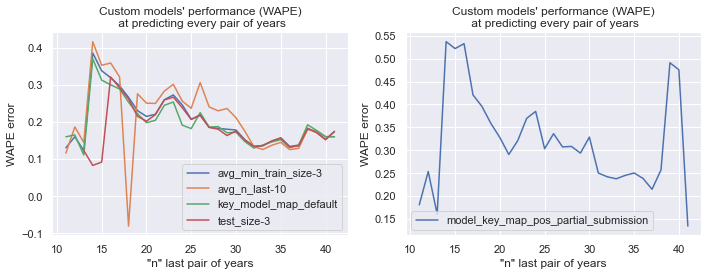

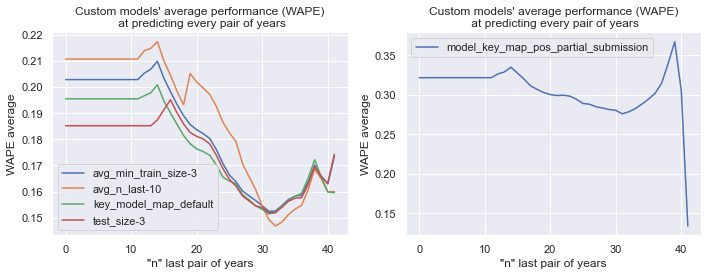

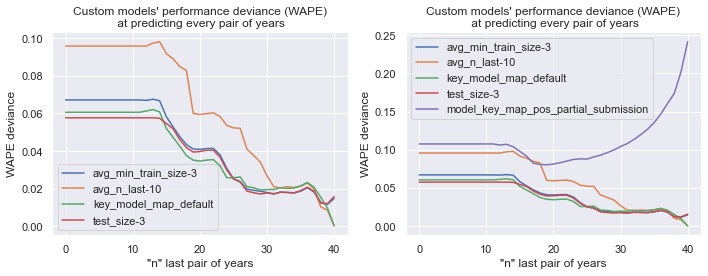

In [19]:
TSmodeling.plot_scrs_stats(
    selected_models_scrs, models_keys,
    params_0 = [0, 1, 2, 4],
    params_1 = [3],
    method='value',
    title="Custom models' performance (WAPE)\n at predicting every pair of years",
    ylabel='WAPE error',
    save_path='plots/Model selection.jpg'
)
TSmodeling.plot_scrs_stats(
    selected_models_scrs, models_keys,
    params_0 = [0, 1, 2, 4],
    params_1 = [3],
    method = 'mean',
    title="Custom models' average performance (WAPE)\n at predicting every pair of years",
    ylabel='WAPE average',
)
TSmodeling.plot_scrs_stats(
    selected_models_scrs, models_keys,
    params_0 = [0, 1, 2, 4],
    params_1 = [0, 1, 2, 4, 3],
    method='std', #'mean'
    title="Custom models' performance deviance (WAPE)\n at predicting every pair of years",
    ylabel='WAPE deviance',
)

#### Conclusions:
    * Default parameters presented the smallest average wape error error for any "n" last pairs of testing values, compared to the other results of model selection for the second set of paramters.
    Obs: The chart in the left shows the average wape for any 'n' consecutive last pais of testing values for models used in the partial submission. It is noticiable that the error drops fast for the predictino of the last pair of values (2016 and 2017) but performance drops for other years (overfitted to 2016 and 2017)

---
# 5 VISUALIZING SELECTED MODEL RESULTS (best performing model: default parameters)

### 5.1 Reloading default parameters model results

In [29]:
# reloading default parameters serie-model dictionary
keys_models = json.load(open('models/key_model_map_default.json', 'r'))
# reload default parameters model prediction
yhat_i = ts_modeling.load_csv_folder('predictions/key_model_map_default/')

### 5.2 Calculating product type average scores and adding year columns

In [30]:
# select default parameters model prediction scores
prod_scrs = selected_models_scrs['key_model_map_default'].copy()
# Calculate WAPE average by product type 
prod_scrs['average'] = prod_scrs.mean(1)
# format testing and last training years 
prod_scrs['test_years'] = prod_scrs.index.map(lambda i: str(1974+i)+'-'+str(1975+i))
prod_scrs['last_train_year'] = prod_scrs.index.map(lambda i: str(1973+i))

### 5.3 Counting how many time series are associated to each model

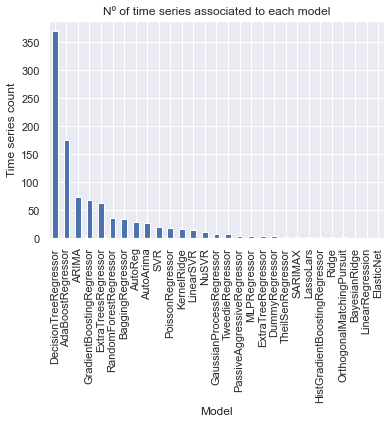

In [31]:
# Count how many time series are associated to each model
model_importance = pd.Series(list(keys_models.values())).value_counts()
# Plotting time series count
model_importance.plot.bar()
plt.title('Nº of time series associated to each model')
plt.xlabel('Model'); plt.ylabel('Time series count');
#plt.savefig('plots/Model importance.jpg'); plt.show()

In [ ]:
'RandomForestRegression', 'BaggingRegressor', 'SVR', 'PoissonRegressor', 'KernelRidge', 'LinearSVR', 'NuSVR'

### 5.4 Visualizing performance by product type for pairs of consecutive years
#### 5.4.1 Product types' WAPE errors for every pair of consecutive years, trained with the previous years

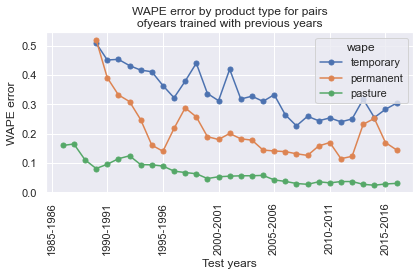

In [23]:
fig, ax = plt.subplots(tight_layout=True)
prod_scrs.set_index('test_years').drop('average', 1).plot(ax=ax, marker='o', ms=5)
plt.xticks(rotation=90)
ax.set(
    title='WAPE error by product type for pairs\nofyears trained with previous years',
    xlabel='Test years', ylabel='WAPE error'
)
plt.savefig('plots/Model performance by product.jpg')
plt.show()

#### 5.4.2 Average WAPE error of product types for the past 7 pairs of consecutive years

In [24]:
prod_scrs.set_index('last_train_year')[['test_years', 'average']].iloc[-7:]

wape,test_years,average
last_train_year,,
2009,2010-2011,0.151771
2010,2011-2012,0.130450
2011,2012-2013,0.136479
2012,2013-2014,0.192033
2013,2014-2015,0.176872
2014,2015-2016,0.160251
2015,2016-2017,0.159587


#### 5.4.3 Average wape deviance of last 7 pairs of consecutive years

In [25]:
prod_scrs.iloc[-7:, :3].mean(1).std()

0.021535512647695244

---
# 6. Building submission table

### 6.1 Making "future" predictions for 2018 and 2019 with selected models and saving results

In [23]:
# final index of initial training sample
n_min = 43
# position of last sample to predict
n = 46
# size of consecutive testing samples to forecast
test_size = 2
# minimun training size when forecasting 
min_train_size = 1
# minimum number of non empty values to score consecutive testing samples
min_test_size = 0
# drop na values from prediction
dropna = False

In [24]:
map_models_predictions = ts_modeling.maps_predictions(
    lab_ind_series, regressors, target, n_min, n, test_size,
    min_train_size, min_test_size, dropna,
    path='models/', filter_by='default', # change 'min_test_size' to zero and 'dropna' to False
    save_path='future predictions/'                 # to predict future (non-included) test_samples (when n > n_samples)
)

Keys predicted: 1009/1010


### 6.2 Reload prediction and build submission table for 2018 and 2019

In [14]:
### 6.0 Functions to reload model predictions and build submission table
# 6.0.1 Convert predictions 'yhat' to submission table format
def build_submission_table(yhat, keys, prodtype_map, years=['2018-01-01', '2019-01-01']):
    cnt, df_values = 0, []
    for key in keys:
        info = key.split('-')
        city_code = info[0]; product = info[1]
        if len(info) == 3: prodtype=info[2]
        else: prodtype = prodtype_map[product]
        for year in years:
            df_values.append([year, city_code, product, prodtype, yhat.iloc[cnt]])
            cnt+=1
    return pd.DataFrame(df_values, columns=['year', 'city_code', 'product', 'product_type', 'destinated_area'])

# 6.0.2 Reload model prediction and build submission table
def final_submission(model_path, pred_path, pred_index, prodtype_map, years=['2018-01-01', '2019-01-01'], save_path=None):
    key_model_map = json.load(open(model_path, 'r'))
    map_keys = list(key_model_map.keys())
    yhat_i = ts_modeling.load_csv_folder(pred_path)
    yhat = yhat_i[pred_index]
    submission = build_submission_table(yhat, map_keys, prodtype_map, years)
    if save_path is not None:
        try: os.mkdir(''.join(save_path.split('/')[:-1]))
        except: None
        submission.to_csv(save_path, index=True)
    return submission

#### 6.2.1 Building final submission table

In [15]:
model_path = 'models/key_model_map_default.json'
pred_path = 'future predictions/key_model_map_default/'
pred_index = 44
prodtype_map = dict(data.groupby(['product', 'product_type']).max().index)
years = ['2018-01-01', '2019-01-01']
save_path = 'submission/pos_final_submission.csv'

In [27]:
submission = final_submission(model_path, pred_path, pred_index, prodtype_map, years, save_path=None)

#### 6.2.2 Displaying final submission table

In [117]:
submission.head(3)

,year,city_code,product,product_type,destinated_area
0,2018-01-01,0307883b5d063703,Cassava,temporary,115.920000
1,2019-01-01,0307883b5d063703,Cassava,temporary,115.920000
2,2018-01-01,0307883b5d063703,Livestock,pasture,8384.741529


---
# 7. Visualizing final model predictions

In [16]:
def rebuild_prediction_series(yhat_i, models_keys, base_year=1974):

    pred_series_first, pred_series_second = [], []
    n_keys = len(models_keys)
    pair_index = list(range(0, n_keys*2, 2))
    even_index = list(range(1, n_keys*2, 2))
    last_train_max = max(yhat_i.keys())
    last_train_i = np.array(range(1, last_train_max+1))
    for last_train in last_train_i:
        yhat = yhat_i[last_train].copy()
        year_1 = yhat.iloc[pair_index].copy()
        year_2 = yhat.iloc[even_index].copy()
        pred_series_first.append(year_1.values)
        pred_series_second.append(year_2.values)

    X_pred_0 = pd.DataFrame(pred_series_first, columns=models_keys, index=last_train_i+base_year)
    X_pred_1 = pd.DataFrame(pred_series_second, columns=models_keys, index=last_train_i+base_year+1)
    return X_pred_0, X_pred_1

def plot_random_pred(
    X, keys, models, X_pred_0=None, X_pred_1=None,
    exclude=[], n_series=12, n_cols=3, figsize=[5, 3],
    x_params={'marker': 'o', 'ms': 3, 'lw': 5},
    pred_0_params={'marker': 'x', 'ms': 5},
    pred_1_params={'marker': 'x', 'ms': 5},
):
    
    sample_keys = np.random.choice(list(filter(lambda key: models[key] not in exclude, keys)), n_series)
    n_rows = n_series//n_cols if n_series%n_cols==0 else n_series//n_cols+1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0]*n_cols, figsize[1]*n_rows), tight_layout=True)
    row, col = 0, 0
    for key in sample_keys:
        X[key].plot(ax=axes[row][col], **x_params)
        if X_pred_0 is not None: X_pred_0[key].plot(ax=axes[row][col], **pred_0_params)
        if X_pred_1 is not None: X_pred_1[key].plot(ax=axes[row][col], **pred_1_params)
        axes[row][col].set(
            title=f'Real vs predicted land areas in Para cities\n{models[key]}\n{key}',
            ylabel='land area (hec)',
            xlabel='years'
        )
        col+=1
        if col==n_cols:
            col = 0; row+=1
    plt.show()

### 7.1 Making "future" predictions for all pairs of years until 2020

In [17]:
# final index of initial training sample
n_min = 0
# position of last sample to predict
n = 48 # 46 predicts up to 2018-2019
# size of consecutive testing samples to forecast
test_size = 2
# minimun training size when forecasting 
min_train_size = 1
# minimum number of non empty values to score consecutive testing samples
min_test_size = 0 # Change to zero to predict future values
# drop na values from prediction
dropna = False

In [ ]:
map_models_predictions = ts_modeling.maps_predictions(
    lab_ind_series, regressors, target, n_min, n, test_size,
    min_train_size, min_test_size, dropna,
    path='models/', filter_by='default', # change 'min_test_size' to zero and 'dropna' to False
    save_path='predictions/'                 # to predict future (non-included) test_samples (when n > n_samples)
)

### 7.2 Reloading selected model results and predictions

In [12]:
# reloading default parameters serie-model dictionary
keys_models = json.load(open('models/key_model_map_default.json', 'r'))
models_keys = list(keys_models.keys())
n_keys = len(models_keys)

# reload default parameters model prediction
yhat_i = ts_modeling.load_csv_folder('predictions/key_model_map_default/')
index_key_map = tools.category_index.get_key_index_test_map(series, data.index)

# Reloading true values
X = pd.read_csv('data/series_raw.csv', index_col=0).reset_index(drop=True)       # time series as columns dataframe (complete)
X.index = X.index.values + 1974

X_pred_0, X_pred_1 = TSmodeling.rebuild_prediction_series(yhat_i, models_keys)

### 7.3 Visualizing predictions

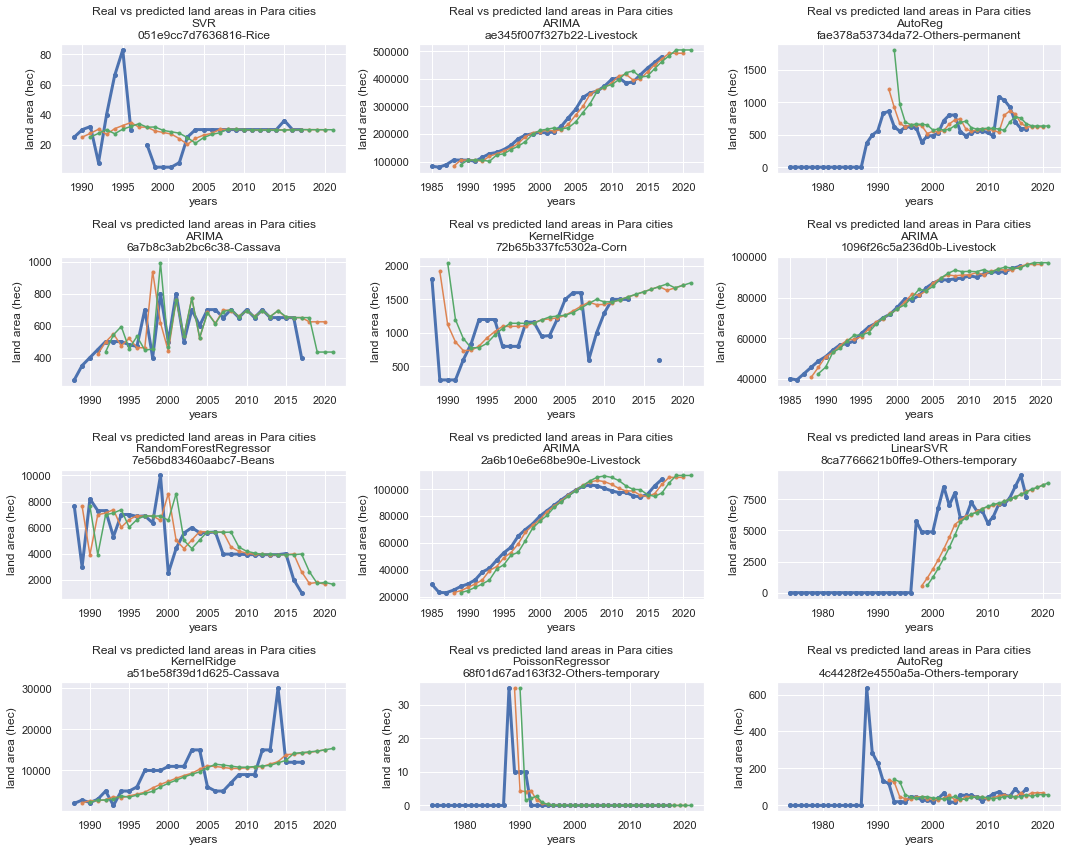

In [24]:
TSmodeling.plot_random_pred(
    X, models_keys, keys_models, X_pred_0, X_pred_1,
    exclude=['DecisionTreeRegressor', 'AdaBoostRegressor', 'ExtraTreesRegressor',
             'GradientBoostingRegressor', 'ExtraTreeRegressor'], n_series=12, n_cols=3, figsize=[5, 3],
    x_params={'marker': 'o', 'ms': 4, 'lw': 3},
    pred_0_params={'marker':'o', 'ms': 3, 'lw': 1.5},
    pred_1_params={'marker':'o', 'ms': 3, 'lw': 1.5},
)